# Final Project Report - DAT650, Blockchain Technology - University of Stavanger - Fall, 2021

###### Mohammed Z. Guniem & Essandoh Raymond <br>

* In this project, we investigate the effects each of the three main constraints have on selfish mining strategy and how profitable it is relative to honest mining, these constraints are:<br>
    1. The mining power.<br>
    2. The network power.<br>
    3. The number of selfish miners vs. the number of honest miners. <br><br>

* To better isolate and observe the effect of mining and network power, we choose to:<br>
    1. Set the network power to be random by picking a random blockchain when blockchain forks appear as a result of selfish mining when simulating/varying the selfish mining power.<br>
    2. Set the mining power to be equal for each miner in the simulation when simulating/varying the selfish network power.<br>

<br />

* In addition we plan on investigating how profitable both of the stubborn and GHOST mining in comparison to selfish mining.

<br />

* Also, at the start we try to find the a suitable target difficulty that give us enough forks with as low running time as possible. 

<br />

* Please Note! We are repeating each of simulations 1 to 6 (10 times) and then taking the average of the results as an output value for a simulation. This increases the reliability of our simulation results and avoid having a deviation result.  

<br />

* The table below explains the multiple simulations that is carried out in this notebook.

| Number of Simulation | Simulation Goal | Total Number of Miners | Number of Selfish Miners | Number of Honest Miners | Mining Power | Network Power |
| --- | --- | --- | --- | --- | --- | --- |
| 0 | Study the correlation between the target difficulty and number of forks, in order to choose a suitable difficulty for the next simulations | 100 miners. | 50 selfish. | 50 honest. | 100 units of mining power available, each miner has a mining power of 1. | Random for all miners when blockchain forks appear. |
| 1 | Study the effect of an increasing mining power of just one selfish miner. | 100 miners. | 1 selfish. | 99 honest. | 100 units of mining power available, Increasing the mining power of the one selfish miner and decreasing the mining power of the honest miner(s) throughout the simulations. | Random for all miners when blockchain forks appear. |
| 2 | Study the effect of an increasing selfish mining power as a result of increasing the number of selfish miners and decreasing the number of honest miners. | 100 miners. | Increasing the number of selfish miners by 1 and therefore the total selfish mining power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest mining power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | Random for all miners when blockchain forks appear. |
| 3 | Study the effect of an increasing network power of just one selfish miner. | 100 miners. | 1 selfish. | 99 honest. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | 100 units of network power available, Increasing the network power of the one selfish miner and decreasing the network power of the honest miner(s) throughout the simulations, the higher the network power is, the higher the chances are for a miner to replicate his block across the network. |
| 4 | Study the effect of an increasing selfish network power as a result of increasing the number of selfish miners and decreasing the number of honest miners. | 100 miners. | Increasing the number of selfish miners by 1 and therefore the total selfish network power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest network power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | 100 units of network power available, distributed equally among 100 miners where each miner gets 1 unit of power, the higher the network power is, the higher the chances are for a miner to replicate his block across the network when blockchain forks appear. |
| 5 | Study the effect of GHOST mining when increasing the number of selfish miners following the GHOST strategy and decreasing the number of honest miners. | 100 miners. | Increasing the number of GHOST selfish miners by 1 and therefore the total GHOST selfish mining power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest mining power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | Random for all miners when blockchain forks appear. |
| 6 | Study the effect of Stubborn mining of in a block size range between 1 and 3 when increasing the number of stubborn miners following the Stubborn strategy and decreasing the number of honest miners. | 100 miners. | Increasing the number of stubborn miners by 1 and therefore the total stubborn mining power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest mining power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. |  Random for all miners when blockchain forks appear. |

In [1]:
"""
Here, we declare and construct classes for Block, Blockchain, 
Honest Miner and Selfish Miner along with other helping methods in the cell below.
"""

import random
import hashlib as hasher

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        r = random.choices(maxes, k=1)
        return r[0], len(maxes)
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last, _ = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock, _ = blockchain.longestChain()
  
    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        return num_forks
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True
        return num_forks

    def PoWSolver(self):
        #add this function - selfish PoW
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

In [2]:
"""
A method that runs the simulations of mining

Inputs: 
- The blockchain instance (bc),
- An array of honest miners (honest_miners),
- An array of non_honest miners (non_honest_miners)

Outputs:
- An array containing the percentage of blocks mined by each honest miner (honest_profits)
- An array containing the percentage of blocks mined by each non_honest miner (non_honest_profits)
- Number of forks discovered by non_honest miners (sum(forks_non_honest))
- Number of forks discovered by honest miners (sum(forks_honest))
"""
def simulate_mining(bc, honest_miners, non_honest_miners):
    run_to = 101
    forks_honest = []
    forks_non_honest = []
    while bc.size < run_to:
        for s in non_honest_miners:
            s.PoWSolver()

        for m in honest_miners:
            m.PoWSolver()

        for s in non_honest_miners:
            num_forks_non_honest = s.UpdateLast()
            forks_non_honest.append(num_forks_non_honest)
            
        for m in honest_miners:
            num_forks_honest = m.UpdateLast()
            forks_honest.append(num_forks_honest)
            
    longestchain, _ = bc.longestChain()
    bc_height = longestchain.height
    
    non_honest_profits = []
    for non_honest_miner in non_honest_miners:
        percentage_of_miner_blocks = bc.checkMiner(non_honest_miner) / bc_height
        non_honest_profits.append(percentage_of_miner_blocks)
    
    honest_profits = []
    for honest_miner in honest_miners:
        percentage_of_miner_blocks = bc.checkMiner(honest_miner) / bc_height
        honest_profits.append(percentage_of_miner_blocks)
        
    return non_honest_profits, honest_profits, sum(forks_non_honest), sum(forks_honest)

### Difficulty vs. Number of forks
### Simulation nr. 0: 
In this simulation, we aim to study the correlation between the target difficulty and number of forks, in order to choose a suitable difficulty for the next simulations the simulation has the following setup:<br/><br/>

A) Total number of miners is 100.<br/><br/>
B) 50 honest miners, and 50 selfish miners at all times.<br/><br/>
C) Total available mining power of 100 units, 1 power unit for each miners at all times.<br/><br/>
D) We increase the difficulty from 0 to 10 and observe the number of forks that has occured during both honest and selfish mining and in total.<br/><br/>
E) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.<br/><br/>

In [3]:
"""
This method makes miners of a given type (selfish/honest), and
equally assign mining power to each miner within 
the given limits of mining power and number of miners.

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80, blockchain)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="selfish", num_of_miners=60, total_mining_power=20, blockchain)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    (i.e. mining power of 0). 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if remaining_mining_power == 0:
            mining_power = 0
        elif len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            remaining_mining_power -= mining_power
            
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 0, see table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
number_of_forks_total = []
number_of_forks_honest = []
number_of_forks_selfish = []
sim_difficulty = range(0, 11, 1)

total_mining_power = 100
honest_mining_power = 50
selfish_mining_power = 50
num_of_selfish_miners = 50
num_of_honest_miners = 50

if output:
    print(f"-> {num_of_honest_miners} honest minors having {round(honest_mining_power)}% of total mining power")
    print(f"-> {num_of_selfish_miners} selfish minors having {round(selfish_mining_power)}% of total mining power")
    print()     
        
for difficulty in sim_difficulty:
    if output:
        print(f"Running simulation with difficulty {difficulty}:")
        
    bc = Blockchain("0" , difficulty)
    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)

    _, _, num_forks_selfish, num_forks_honest = simulate_mining(bc, honest_miners, selfish_miners)
    
    number_of_forks_selfish.append(num_forks_selfish)
    number_of_forks_honest.append(num_forks_honest)
    number_of_forks_total.append(num_forks_honest+num_forks_selfish)
    
    if output:
        print(f"Resulted Number of Honest Forks: {num_forks_honest}")
        print(f"Resulted Number of Selfish Forks: {num_forks_selfish}")
        print(f"Resulted Total Number of Forks: {num_forks_honest+num_forks_selfish}")
        print()


-> 50 honest minors having 50% of total mining power
-> 50 selfish minors having 50% of total mining power

Running simulation with difficulty 0:
Resulted Number of Honest Forks: 10000
Resulted Number of Selfish Forks: 8725
Resulted Total Number of Forks: 18725

Running simulation with difficulty 1:
Resulted Number of Honest Forks: 7850
Resulted Number of Selfish Forks: 6328
Resulted Total Number of Forks: 14178

Running simulation with difficulty 2:
Resulted Number of Honest Forks: 5150
Resulted Number of Selfish Forks: 3934
Resulted Total Number of Forks: 9084

Running simulation with difficulty 3:
Resulted Number of Honest Forks: 5100
Resulted Number of Selfish Forks: 4060
Resulted Total Number of Forks: 9160

Running simulation with difficulty 4:
Resulted Number of Honest Forks: 5050
Resulted Number of Selfish Forks: 3985
Resulted Total Number of Forks: 9035

Running simulation with difficulty 5:
Resulted Number of Honest Forks: 6050
Resulted Number of Selfish Forks: 4866
Resulted 

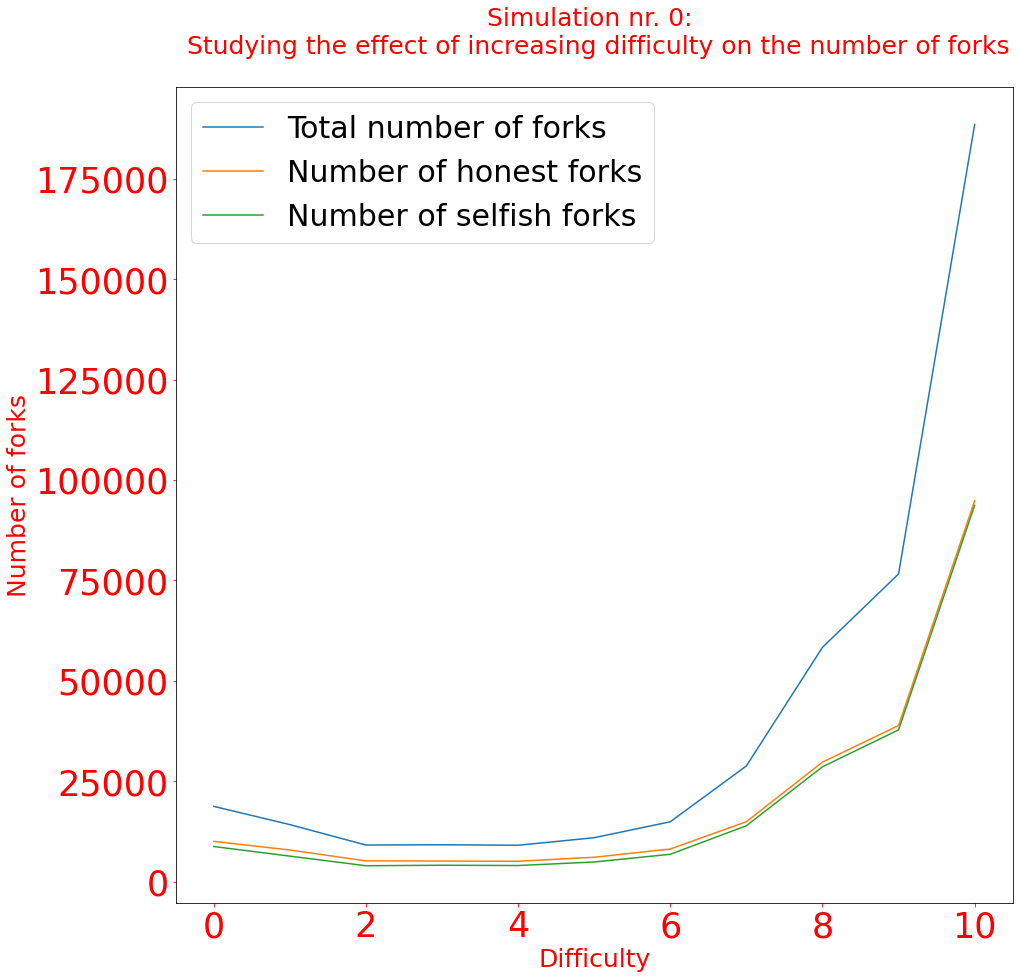

In [4]:
"""
Drawing the results of the previous simulation nr. 0
"""

import matplotlib.pyplot as plt

difficulty_range = list(sim_difficulty)

fig, axs = plt.subplots(1, 1, figsize=(15,15))

axs.plot(difficulty_range, number_of_forks_total, label = "Total number of forks")
axs.plot(difficulty_range, number_of_forks_honest, label = "Number of honest forks")
axs.plot(difficulty_range, number_of_forks_selfish, label = "Number of selfish forks")
axs.tick_params(axis='x', colors='red')
axs.tick_params(axis='y', colors='red')
axs.set_title('Simulation nr. 0: \n Studying the effect of increasing difficulty on the number of forks\n', fontsize=25).set_color('red')
axs.set_xlabel('Difficulty', fontsize=25).set_color('red')
axs.set_ylabel('Number of forks', fontsize=25).set_color('red')
axs.legend(prop={"size":30})
l = plt.setp(axs.get_xticklabels(), fontsize=35)
l = plt.setp(axs.get_yticklabels(), fontsize=35)


### Analysis and Comments on Simulation Results nr. 0
When we have increasing difficulty in an ecosystem where there are 50 honest and 50 selfish miners, and each miner have equal mining power and random network power, we observe the following:<br><br>
A) The lowest number of forks appears when the difficulty is between 2 and 4.<br><br>
B) After 4, the number of occuring forks grows logarithmic.<br><br>
C) Observation 1 and 2 above apply for all forks occuring under both honest and selfish mining, and therefore it also apply for the total sum of forks.<br><br>
D) From the plot above, all plot lines of the sum of forks does have an albue at difficulty 6 to 8 with a moderate number of forks occuring which is about 25 000 or less.<br><br>
E) Based on that we choose 7 as the initial target diffculty to our future simulations, but we will still keep track of the number of forks occuring, this is because forks are important to all of Selfish-, GHOST- and Stubborn- mining. as these strategies play out during the forking of blockchains. 

### Mining Power Simulation & Analysis
### Simulation nr. 1: 
In this simulation, we aim to study the effect of an increasing mining power of just one selfish miner, the simulation has the following setup:<br/><br/>
A) Total available mining power of 100.<br/><br/>
B) Starting the total selfish mining power at 0% of the total available mining power.<br/><br/>
C) Starting the total honest mining power at 50% of the total available mining power.<br/><br/>
D) Total number of miners is 100; 99 honest miners and 1 selfish miner at all times.<br/><br/>
E) Mining power will vary from one miner to another, beacuse we are:<br/><br/>
    1. Increasing the mining power of the 1 selfish miner from 0 to 50 with selfish_mining_power += 1 at each step.<br/>
    2. Decreasing the mining power of the 99 honest miners from 50 to 1 with honest_mining_power -= 1 at each step.<br/><br/>
F) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.<br/><br/>

Please note that we are only interested in observing a selfish mining power up to 51% as after that it is naturally more profitable to run a 51% attack instead of selfish mining attack.

In [ ]:
"""
This method makes miners of a given type (selfish/honest), and
equally assign mining power to each miner within 
the given limits of mining power and number of miners.

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80, blockchain)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="selfish", num_of_miners=60, total_mining_power=20, blockchain)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    (i.e. mining power of 0). 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if remaining_mining_power == 0:
            mining_power = 0
        elif len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            remaining_mining_power -= mining_power
            
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 1, see table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
all_total_selfish_profits = []
all_total_honest_profits = []
all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []
sim_range_selfish = range(0, 61, 1)
sim_range_honest = range(61, 0, -1)

total_mining_power = 100
num_of_selfish_miners = 1
num_of_honest_miners = 99

repeat_each = 10
    
for selfish_mining_power in sim_range_selfish:
    honest_mining_power = total_mining_power-selfish_mining_power
    
    total_selfish_profits = []
    total_honest_profits = []
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []

    if output:
        print(f"-> {num_of_honest_miners} honest minors having {round(honest_mining_power)}% of total mining power")
        print(f"-> {num_of_selfish_miners} selfish minors having {round(selfish_mining_power)}% of total mining power")
            
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")
            
        bc = Blockchain("0" , 7)
        honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
        selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)

        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_mining(bc, honest_miners, selfish_miners)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100) # multiplying by 100 for bettwer scale on the plot.

        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100) # multiplying by 100 for bettwer scale on the plot.
        
        number_of_forks_selfish.append(num_forks_selfish)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_total.append(num_forks_honest+num_forks_selfish)
        
    selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(selfish_profit)
    
    honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(honest_profit)
    
    num_forks_honest = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_forks_honest)
    
    num_forks_selfish = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish)
    
    num_forks_total = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_forks_total)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {round(selfish_profit+honest_profit)}")
        print(f"Resulted Number of Honest Forks: {num_forks_honest}")
        print(f"Resulted Number of Selfish Forks: {num_forks_selfish}")
        print(f"Resulted Total Number of Forks: {num_forks_total}")
        print()


-> 99 honest minors having 100% of total mining power
-> 1 selfish minors having 0% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 100.28814262023212
Total Percentage Sum of Selfish Profit: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 18414.0
Resulted Number of Selfish Forks: 186.0
Resulted Total Number of Forks: 18600.0

-> 99 honest minors having 99% of total mining power
->

Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 92.9260923538794
Total Percentage Sum of Selfish Profit: 6.905065216070395
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 19156.5
Resulted Number of Selfish Forks: 187.6
Resulted Total Number of Forks: 19344.1

-> 99 honest minors having 91% of total mining power
-> 1 selfish minors having 9% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out 

In [ ]:
"""
Drawing the results of the previous simulation nr. 1
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)


fig, axs = plt.subplots(1, 2, figsize=(50,20))

# Plot 1: Percentage of selfish and honest profit with increasing selfish mining power
axs[0].plot(selfish_power, all_total_selfish_profits, label = "1 selfish miner")
axs[0].plot(selfish_power, all_total_honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_title('Simulation nr. 1: \n 99 honest and 1 selfish miners \n increasing the mining power of the 1 selfish miner\n', fontsize=25).set_color('red')
axs[0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=25).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=25).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

# Plot 2: Number of occurring forks during selfish and honest mining, and their combined total.
axs[1].plot(selfish_power, all_number_of_forks_total, label = "Total number of forks")
axs[1].plot(selfish_power, all_number_of_forks_honest, label = "Number of honest forks")
axs[1].plot(selfish_power, all_number_of_forks_selfish, label = "Number of selfish forks")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_title('Simulation nr. 1: \n Number of forks vs. selfish mining power\n', fontsize=25).set_color('red')
axs[1].set_xlabel('Selfish Mining Power', fontsize=25).set_color('red')
axs[1].set_ylabel('Number of forks', fontsize=25).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)


### Analysis and Comments on Simulation Results nr. 1
When we have 1 selfish miner and 99 honest miners, and we then increase the mining power of the selfish miner, while decreasing the mining power of the 99 honest miners, we observe the following:<br><br>

A) Selfish mining is more likely to be less profitable than honest mining as long as the one selfish miner has a mining power under 35% of the total mining power, but profit of selfish mining is increasing with the increased mining power of the selfish miner.<br><br>
B) However, when the selfish mining power is more than 35% of the total mining power, there exist a big competition between both types of miners.<br><br>
C) But does that mean selfish mining is a good strategy? The one Selfish miner was able to climb from 0% to 40% of total profit for a mining power less than 35%, perhaps it is a good strategy as long as the selfish miner is having a high mining power share of the total mining power compared to other miners.<br><br>
D) Looking at the right plot above where the number of forks is plotted; we clearly see that the number of forks faced by the selfish miner is stable and much lower than it is for the forks discovered by honest mining. This could be a side effect of having just 1 selfish miner against 99 other honest miners.<br><br>
E) Also as it is not expected the selfish mining becomes less profitable than honest mining after 51% selfish power share, this can also be due to the one only selfish miner against the other 99 honest miners, but if a miner have a 51% mining power of more, then it is much better and more profitable for him/her to run a 51% attack than selfish mining.

### Mining Power Analysis and Simulation
### Simulation nr. 2: 
In this simulation we aim to study the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal mining power, but where the number of selfish miners increases by 1, and at the same time the number of honest miners decreases by 1. This simulation has the following setup:<br><br>
A) Total number of miners is 100.<br><br>
B) Total available mining power of 100 units, 1 unit for each miner at all times.<br><br>
C) Starting the total selfish mining power at 0 (i.e. 0 selfish miners)<br><br>
D) Starting the total honest mining power at 100 (i.e. 100 honest miners)<br><br>
E) Each miner will have the same mining power as other miners, beacuse we are
* Increasing the selfish mining power from 0 to 99 with selfish_mining_power += 1, and 
    at the same time increasing the number of selfish miners from 0 to 99 with 
    num_selfish_miners += 1<br><br>
* Decreasing the honest mining power from 100 to 1 with honest_mining_power -= 1, and 
    at the same time decreasing the number of honest miners from 100 to 0 with 
    num_honest_miners -= 1<br><br>
    
F) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.

In [ ]:
"""
This method makes miners of a given type of miners (selfish/honest), and
equally assign mining power to each miner within 
the given limits of mining power and number of miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="honest", num_of_miners=60, total_mining_power=20)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    i.e. mining power of 0. 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

"""
The code below runs simulation nr. 2, se table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
all_total_selfish_profits = []
all_total_honest_profits = []

all_average_selfish_profits = []
all_average_honest_profits = []

all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []

sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

repeat_each = 10

for selfish_power in sim_range_selfish:
    total_mining_power = 100
    
    num_of_honest_miners = total_mining_power-selfish_power
    honest_power_share = round(num_of_honest_miners/100, 2)
    honest_mining_power = round(total_mining_power * honest_power_share)
    
    num_of_selfish_miners = selfish_power
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    total_selfish_profits = []
    total_honest_profits = []
    
    avg_selfish_profits = []
    avg_honest_profits = []
    
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []
    
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {num_of_honest_miners} honest miners having {round(honest_mining_power)}% of total mining power")
        print(f"-> {num_of_selfish_miners} selfish miners having {round(selfish_mining_power)}% of total mining power")
        print()
        
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")
            
        bc = Blockchain("0" , 7)
    
        honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power)
        selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power)
        
        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_mining(bc, honest_miners, selfish_miners)
        
        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100)
    
        if len(selfish_profits) != 0:
            average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
        else:
            average_selfish_profit = 0
        avg_selfish_profits.append(average_selfish_profit*100) # multiplied by 100 for better scale 
        
        if len(honest_profits) != 0:
            average_honest_profit = sum(honest_profits) / len(honest_profits)
        else:
            average_honest_profit = 0
        avg_honest_profits.append(average_honest_profit*100)
        
        number_of_forks_total.append(num_forks_selfish+num_forks_honest)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_selfish.append(num_forks_selfish)
        
    sum_honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(sum_honest_profit)
    
    sum_selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(sum_selfish_profit)
    
    average_honest_profit = sum(avg_honest_profits) / len(avg_honest_profits)
    all_average_honest_profits.append(average_honest_profit)
    
    average_selfish_profit = sum(avg_selfish_profits) / len(avg_selfish_profits)
    all_average_selfish_profits.append(average_selfish_profit) 
    
    num_honest_forks = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_honest_forks)
    
    num_selfish_forks = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish) 
    
    num_total_forks = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_total_forks)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {sum_selfish_profit+sum_honest_profit}")
        print(f"Resulted Number of Honest Forks: {num_honest_forks}")
        print(f"Resulted Number of Selfish Forks: {num_selfish_forks}")
        print(f"Resulted Total Number of Forks: {num_total_forks}")
        print()

In [ ]:
"""
Drawing the results of the previous simulation nr. 2
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(2, 2, figsize=(50,60))
fig.suptitle('Simulation nr. 2: \n Increasing the mining power of selfish mining by increasing the number of selfish miners \n All miners has the same mining power\n', fontsize=45).set_color('red')  

# Plot 1: Percentage of selfish and honest profit with increasing selfish mining power
axs[0, 0].plot(selfish_power, all_total_selfish_profits, label = "Selfish mining")
axs[0, 0].plot(selfish_power, all_total_honest_profits, label = "Honest mining")
axs[0, 0].tick_params(axis='x', colors='red')
axs[0, 0].tick_params(axis='y', colors='red')
axs[0, 0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[0, 0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 0].legend(prop={"size":30})
l = plt.setp(axs[0, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 0].get_yticklabels(), fontsize=35)

# Plot 2: Average of profit between miners
axs[0, 1].plot(selfish_power, all_average_selfish_profits, label = "Selfish mining")
axs[0, 1].plot(selfish_power, all_average_honest_profits, label = "Honest mining")
axs[0, 1].tick_params(axis='x', colors='red')
axs[0, 1].tick_params(axis='y', colors='red')
axs[0, 1].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[0, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 1].legend(prop={"size":30})
l = plt.setp(axs[0, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 1].get_yticklabels(), fontsize=35)

# Plot 3: Number of occurring forks during both selfish and honest mining
axs[1, 0].plot(selfish_power, all_number_of_forks_selfish, label = "#Forks at selfish mining")
axs[1, 0].plot(selfish_power, all_number_of_forks_honest, label = "#Forks at honest mining")
axs[1, 0].tick_params(axis='x', colors='red')
axs[1, 0].tick_params(axis='y', colors='red')
axs[1, 0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[1, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 0].legend(prop={"size":30})
l = plt.setp(axs[1, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 0].get_yticklabels(), fontsize=35)

# plot 4: Total number of occurring forks.
axs[1, 1].plot(selfish_power, all_number_of_forks_total, label = "#Forks in total")
axs[1, 1].tick_params(axis='x', colors='red')
axs[1, 1].tick_params(axis='y', colors='red')
axs[1, 1].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[1, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 1].legend(prop={"size":30})
l = plt.setp(axs[1, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 1].get_yticklabels(), fontsize=35)

## Analysis and Comments on Simulation Results nr. 2
When we increase the selfish mining power by inreasing the number of selfish miners and decreasing the number of honest miners, we observe the following:<br><br>

A) Selfish mining is less profitable than honest mining under 60% selfish mining power.<br><br>

B) However, the profit inreases with increased number of selfish miners, and the same happens for honest miners as well but in the opposite direction because of the decrease in the number of honest miners.<br><br>

C) The average plot in the upper right corner above shows that on average, an honest miner gets a bigger share in the total profit of honest mining, than the share of a selfish miner in the total profit of selfish mining.<br><br>

D) The upper 2 plots show that selfish mining is depending on the honest miners to make more profit, this is because we observe lower share for the average selfish miner in the selfish profit than the share of the average honest miner in the honest profit, even after these power intervals (after 70 selfish miners) where the selfish profit is higher than the honest profit in total.<br><br>

E) In the lower 2 plots, we observe that the number of forks occuring during honest mining decreases along the decrease of honest miners, and the same relation applies for the increase of selfish miners. However, selfish miners tends to face much more forks when increasing the number of selfish miners due to the operation of selfish mining.


### Network Power Simulation & Analysis
### The following redesign steps was added to the previous core classes to implement a way to simulate network power<br>

A) Network Power will be used in the longestChain() method to increase the chances of a certain block creator to have his block and its previous blockchain replicated faster than other blocks from other miners with low network power, this simulation method is also known as weighted random. <br><br>

B) Please note that the block is still chossen randomly in the longestChain() method. However, now we are increasing the chances by checking the network power of the miner who created that block and if it is found out to be smaller than a randomly generated number between 0 to 100 than his block gets replicated and if not, his block does not get replicated across the network in the simulation. <br><br>

C) Redesigning the longestChain() method in the Blockchain class to simulate network power.<br><br>

D) Adding an additional attribute to define the network power of a certain miner in the Miner and SelfishMiner classes.<br><br>

E) Editing the Block class to implement the changes in above.<br><br>

The cell below implement these specified changes.

In [ ]:
class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            if creator != None:
                self.creator = Miner(0 , creator.networkingPower, creator.miner_type ,"0")
            else:
                self.creator = Miner(0 , None, None, "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))


class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        new_maxes = []
        if len(maxes) > 1:
            chances = list(range(1, 101, 1))
            choice = random.choice(chances)
            for block in maxes:
                creator_networking_power = block.creator.networkingPower
                if choice <= creator_networking_power:
                    new_maxes.append(block)
        else:
            new_maxes = maxes
            
        if len(new_maxes) == 0:
            new_maxes = maxes
        return new_maxes[0], len(maxes)
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last, _ = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        self.miningPower = miningPower
        self.networkingPower = networkingPower
        self.miner_type = miner_type
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock, _ = blockchain.longestChain()
  
    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        return num_forks
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        super().__init__(miningPower, networkingPower, miner_type, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True
        return num_forks

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

### Network Power Analysis and Simulation
### Simulation nr. 3: 
In this simulation, we aim to study the effect of an increasing network power of just one selfish miner against 99 honest miners, the simulation has the following setup:

A) Total available network power of 100.<br><br>

B) Starting the total selfish network power at 0.<br><br>

C) Starting the total honest network power at 100.<br><br>

C) Total number of miners is 100, always having 99 honest miners and 1 selfish miner.<br><br>

D) Network power will vary from one miner to another, beacuse we are <br>
    1. Increasing the network power of the 1 selfish miner from 0 to 99 with selfish_network_power += 1, and <br>
    2. Decreasing the network power of the 99 honest miners from 100 to 1 with honest_network_power -= 1.<br><br>

E) Total mining power is 100 and it is divided equally among all miners, so each miner of the 100 miners will have a mining power of 1 no matter if he is a selfish or honest miner. This is done to isolate the effect of network power from the effect of mining power in the mining results.

In [ ]:
"""
This method makes miners of a given type (selfish/honest), and
divides the mining power share equally on the generated miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", total_network_power=40, num_of_miners=40, total_mining_power=80)
> we should get an array of 40 selfish miners, where each miner has
> 80/40 = 2 mining power, and 40/40 = 1 network power

However if we call the same method with
> make_miners(type_of_minors="honest", total_network_power=40, num_of_miners=60, total_mining_power=40)
> we should get an array of 40 honest miners, where each miner has
> 40/40 = 1 mining power, and
> 40 of these honest miners has a network power of 1 and
> 20 has a network power of 0 (i.e. they are inactive or offline on the network)
"""
def make_miners(type_of_minors, total_network_power, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    remaining_network_power = total_network_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
            network_power = remaining_network_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            if remaining_mining_power < 0:
                mining_power = 0
            else:
                mining_power = 1
            remaining_mining_power -= mining_power
                
            network_power = round(total_network_power/num_of_miners)
            if remaining_network_power <= 0:
                network_power = 0
            else:
                network_power = 1
            remaining_network_power -= network_power
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, network_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)

        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 3, se table at the head of this notebook for summary details
"""
output = True

all_total_selfish_profits = []
all_total_honest_profits = []

all_average_selfish_profits = []
all_average_honest_profits = []

all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []

sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

repeat_each = 10

for selfish_network_power in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    selfish_networking_power = selfish_network_power
    honest_networking_power = 100-selfish_network_power
    
    total_selfish_profits = []
    total_honest_profits = []
    
    avg_selfish_profits = []
    avg_honest_profits = []
    
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []
    
    if output:
        print(f"Running simulation of networking power with:")
        print(f"-> {num_of_honest_miners} honest miners having {honest_networking_power}% of total networking power")
        print(f"-> {num_of_selfish_miners} selfish miners having {selfish_networking_power}% of total networking power")
        print()
    
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")
        
        bc = Blockchain("0" , 7)
    
        honest_miners = make_miners("honest", honest_networking_power, num_of_honest_miners, honest_mining_power, bc)
    
        selfish_miners = make_miners("selfish", selfish_networking_power, num_of_selfish_miners, selfish_mining_power, bc)
    
        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_mining(bc, honest_miners, selfish_miners)
        
        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100)
    
        if len(selfish_profits) != 0:
            average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
        else:
            average_selfish_profit = 0
        avg_selfish_profits.append(average_selfish_profit*100) # multiplied by 100 for better scale 
        
        if len(honest_profits) != 0:
            average_honest_profit = sum(honest_profits) / len(honest_profits)
        else:
            average_honest_profit = 0
        avg_honest_profits.append(average_honest_profit*100)
        
        number_of_forks_total.append(num_forks_selfish+num_forks_honest)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_selfish.append(num_forks_selfish)

    sum_honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(sum_honest_profit)
    
    sum_selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(sum_selfish_profit)
    
    average_honest_profit = sum(avg_honest_profits) / len(avg_honest_profits)
    all_average_honest_profits.append(average_honest_profit)
    
    average_selfish_profit = sum(avg_selfish_profits) / len(avg_selfish_profits)
    all_average_selfish_profits.append(average_selfish_profit) 
    
    num_honest_forks = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_honest_forks)
    
    num_selfish_forks = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish) 
    
    num_total_forks = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_total_forks)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {sum_selfish_profit+sum_honest_profit}")
        print(f"Resulted Number of Honest Forks: {num_honest_forks}")
        print(f"Resulted Number of Selfish Forks: {num_selfish_forks}")
        print(f"Resulted Total Number of Forks: {num_total_forks}")
        print()
    


In [ ]:
"""
Drawing the results of the previous simulation nr. 3
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)


fig, axs = plt.subplots(1, 2, figsize=(50,20))

# Plot 1: Percentage of selfish and honest profit with increasing selfish network power
axs[0].plot(selfish_power, all_total_selfish_profits, label = "1 selfish miner")
axs[0].plot(selfish_power, all_total_honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_title('Simulation nr. 3: \n 99 honest and 1 selfish miners \n increasing the network power of the 1 selfish miner\n', fontsize=25).set_color('red')
axs[0].set_xlabel('Percentage of selfish network power of the total mining power', fontsize=25).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=25).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

# Plot 2: Number of occurring forks during selfish and honest mining, and their combined total.
axs[1].plot(selfish_power, all_number_of_forks_total, label = "Total number of forks")
axs[1].plot(selfish_power, all_number_of_forks_honest, label = "Number of honest forks")
axs[1].plot(selfish_power, all_number_of_forks_selfish, label = "Number of selfish forks")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_title('Simulation nr. 3: \n Number of forks vs. selfish network power\n', fontsize=25).set_color('red')
axs[1].set_xlabel('Selfish Mining Power', fontsize=25).set_color('red')
axs[1].set_ylabel('Number of forks', fontsize=25).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)

## Analysis and Comments on Simulation Results nr. 3
When we increase the network power of just one selfish miner and decrease the total network power of the other 99 honest miners. We observe the following:

A) The maximum achieved profit percentage of the one selfish miner is almost under 5% of total profit, no matter how big of a network power the selfish miner has.<br><br>

B) However, it is possible to notice a small increase in profit when the 1 selfish miner owns more than 80% of the total network power, but this is still not realistic as it is hard for just one miner to own such large share of network power, and the gained selfish profit is still under 5%.<br><br>

C) When it comes to network power, honest mining might be a good strategy for a group of honest miners, and miners with low network power.<br><br>

D) More network power does not help a lonely selfish miner make a significant profit compared to an honest miner. This is visible because the number of forks occuring on the update of selfish mining is much less than the number of forks on the update of honest mining which we see at the right plot above. 

### Network Power Analysis and Simulation
### Simulation nr. 4: 
In this simulation we aim to study the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal network and mining power. This simulation has the following setup:

A) Total available mining power of 100

B) Starting the total selfish network power at 0

C) Starting the total honest network power at 100

D) Total number of miners is 100

E) Each miner will have the same network power as other miners, beacuse we are
1. Increasing the selfish network power from 0 to 99 by 1, and at the same time increasing the number of selfish miners from 0 to 99 by 1.
2. Decreasing the honest network power from 100 to 1 by 1, and at the same time decreasing the number of honest miners from 100 to 1 by 1.

F) Mining power is equally divided among all miners, each miner having a mining power of 1.

In [ ]:
"""
The code below runs simulation nr. 4, se table at the head of this notebook for summary details
"""
output = True
all_total_selfish_profits = []
all_total_honest_profits = []

all_average_selfish_profits = []
all_average_honest_profits = []

all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []

sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

repeat_each = 10

print("Simulating varying network power between miners with")
print("-> equal mining power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    
    total_mining_power = 100
    honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
    selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
    honest_mining_power = round(total_mining_power * honest_mining_power_share)
    selfish_mining_power = round(total_mining_power * selfish_mining_power_share)
    
    total_network_power = 100
    honest_network_power_share = round(num_of_honest_miners/total_network_power, 2)
    selfish_network_power_share = round(num_of_selfish_miners/total_network_power, 2)
    honest_network_power = round(total_network_power * honest_network_power_share)
    selfish_network_power = round(total_network_power * selfish_network_power_share)
    
    
    total_selfish_profits = []
    total_honest_profits = []
    
    avg_selfish_profits = []
    avg_honest_profits = []
    
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []
    
    if output:
        print(f"Running simulation with:")
        print(f"-> {num_of_honest_miners} honest minors having {honest_network_power}% of total networking power and {honest_mining_power}% of total mining power")
        print(f"-> {num_of_selfish_miners} selfish minors having {selfish_network_power}% of total networking power and {selfish_mining_power}% of total mining power")
        print()
        
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")

        bc = Blockchain("0" , 7)
    
        honest_miners = make_miners("honest", honest_network_power, num_of_honest_miners, honest_mining_power, bc)
    
        selfish_miners = make_miners("selfish", selfish_network_power, num_of_selfish_miners, selfish_mining_power, bc)
        
        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_mining(bc, honest_miners, selfish_miners)
        
        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100)
    
        if len(selfish_profits) != 0:
            average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
        else:
            average_selfish_profit = 0
        avg_selfish_profits.append(average_selfish_profit*100) # multiplied by 100 for better scale 
        
        if len(honest_profits) != 0:
            average_honest_profit = sum(honest_profits) / len(honest_profits)
        else:
            average_honest_profit = 0
        avg_honest_profits.append(average_honest_profit*100)
        
        number_of_forks_total.append(num_forks_selfish+num_forks_honest)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_selfish.append(num_forks_selfish)
    
    
    sum_honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(sum_honest_profit)
    
    sum_selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(sum_selfish_profit)
    
    average_honest_profit = sum(avg_honest_profits) / len(avg_honest_profits)
    all_average_honest_profits.append(average_honest_profit)
    
    average_selfish_profit = sum(avg_selfish_profits) / len(avg_selfish_profits)
    all_average_selfish_profits.append(average_selfish_profit) 
    
    num_honest_forks = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_honest_forks)
    
    num_selfish_forks = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish) 
    
    num_total_forks = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_total_forks)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {sum_selfish_profit+sum_honest_profit}")
        print(f"Resulted Number of Honest Forks: {num_honest_forks}")
        print(f"Resulted Number of Selfish Forks: {num_selfish_forks}")
        print(f"Resulted Total Number of Forks: {num_total_forks}")
        print()

In [ ]:
"""
Drawing the results of the previous simulation nr. 4
"""


import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(2, 2, figsize=(50,60))
fig.suptitle('Simulation nr. 4: \n Increasing the network and mining power of selfish mining by increasing the number of selfish miners \n All miners has the same network and mining power\n', fontsize=45).set_color('red')  

# Plot 1: Percentage of selfish and honest profit with increasing selfish network and mining power
axs[0, 0].plot(selfish_power, all_total_selfish_profits, label = "Selfish mining")
axs[0, 0].plot(selfish_power, all_total_honest_profits, label = "Honest mining")
axs[0, 0].tick_params(axis='x', colors='red')
axs[0, 0].tick_params(axis='y', colors='red')
axs[0, 0].set_xlabel('Percentage of selfish network power of the total network power', fontsize=45).set_color('red')
axs[0, 0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 0].legend(prop={"size":30})
l = plt.setp(axs[0, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 0].get_yticklabels(), fontsize=35)

# Plot 2: Average of profit between miners
axs[0, 1].plot(selfish_power, all_average_selfish_profits, label = "Selfish mining")
axs[0, 1].plot(selfish_power, all_average_honest_profits, label = "Honest mining")
axs[0, 1].tick_params(axis='x', colors='red')
axs[0, 1].tick_params(axis='y', colors='red')
axs[0, 1].set_xlabel('Percentage of selfish network power of the total network power', fontsize=45).set_color('red')
axs[0, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 1].legend(prop={"size":30})
l = plt.setp(axs[0, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 1].get_yticklabels(), fontsize=35)

# Plot 3: Number of occurring forks during both selfish and honest mining
axs[1, 0].plot(selfish_power, all_number_of_forks_selfish, label = "#Forks at selfish mining")
axs[1, 0].plot(selfish_power, all_number_of_forks_honest, label = "#Forks at honest mining")
axs[1, 0].tick_params(axis='x', colors='red')
axs[1, 0].tick_params(axis='y', colors='red')
axs[1, 0].set_xlabel('Percentage of selfish network power of the total network power', fontsize=45).set_color('red')
axs[1, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 0].legend(prop={"size":30})
l = plt.setp(axs[1, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 0].get_yticklabels(), fontsize=35)

# plot 4: Total number of occurring forks.
axs[1, 1].plot(selfish_power, all_number_of_forks_total, label = "#Forks in total")
axs[1, 1].tick_params(axis='x', colors='red')
axs[1, 1].tick_params(axis='y', colors='red')
axs[1, 1].set_xlabel('Percentage of selfish network power of the total network power', fontsize=45).set_color('red')
axs[1, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 1].legend(prop={"size":30})
l = plt.setp(axs[1, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 1].get_yticklabels(), fontsize=35)

## Analysis and Comments on Simulation Results nr. 4

When we inrease the selfish network power by inreasing the number of selfish miners and decreasing the number of honest miners, we observe the following:<br><br>

A) Selfish mining is less profitbale under around 80% network power.<br><br>

B) Both of the selfish and honest profits are nearly as equal to each other at around 90%.<br><br>

C) Selfish mining is more profitable when selfish miners all toghether have more than 90% of total network power.<br><br>

D) However for an average miner, it is mostly better to be an honest miner since the average profit made by honest miners is most of the time higher than it is for those selfish miners, which is shown in the average plot on the upper right corner above.<br><br>

E) Similar to the results from simulation nr. 2, we observe in the lower 2 plots above that the number of forks occuring during honest mining decreases along the decrease of honest miners, and the same relation applies for the increase of selfish miners. However, selfish miners tends to face much more forks when increasing the number of selfish miners due to the operation of GHOST selfish mining.

### GHOST Simulation & Analysis 
The following redesign steps was added to the previous core classes to implement GHOST mining:<br><br>

A) Adding a heaviestChain() method in the Blockchain class to get the chain with the most blocks in it.<br><br>

B) Editing the mechanism in the Blockchain class to implement the changes in A) above.<br><br>

In [ ]:
class Blockchain:
    def __init__(self, genesis_data, difficulty, protocol="longest"):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
        self.protocol = protocol

    def lastBlock(self):
        if self.protocol == "longest":
            last, _ = self.longestChain()
            return last
        else:
            heaviest, _ = self.heaviestChain(self.chain[0])
            return heaviest
    
    def longestChain(self): 
        max = self.chain[0]
        for block in self.chain:
            if block.height > max.height:
                max = block
        return max, len(self.chain)

    def heaviestChain(self, root):
        if len(root.children) == 0:
            return root, 0
        else:
            max = root.children[0]
            maxChilds = self.numberOfBlocksInSubtree(max)
            for block in root.children:
                tmp = self.numberOfBlocksInSubtree(block)
                if tmp > maxChilds:
                    max = block
                    maxChilds = tmp
            return self.heaviestChain(max), len(root.children)

    def numberOfBlocksInSubtree(self, block):
      if len(block.children) == 0:
        return 1
      else:
        sum = 0
        for b in block.children:
          sum += self.numberOfBlocksInSubtree(b)
        return 1 + sum

    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        
    def checkMiner(self, miner):
        last, _ = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count

### (GHOST) Greedy Heaviest-Observed Subtree: Simulation & Analysis<br>
### Simulation nr. 5: 
In this simulation we aim to study the effect of the GHOST strategy on selfish mining. This simulation has the following setup:<br><br>

A) Total number of miners 100.<br><br>

B) Total mining power of 100, each miner has a mining power of 1.<br><br>

C) Total network power of 10 000, each miner has a full network power of 100 for random network power.<br><br>

D) We start the simulation with 100 honest miners and 0 GHOST selfish miners.<br><br>

F) We run the simulation for 60 steps, at each step:<br><br>

* Increasing the number for selfish miners following the GHOST strategy by 1, and<br><br>
* Decreasing the number for honest miners by 1.<br><br>

In [ ]:
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    remaining_network_power = total_network_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            if remaining_mining_power < 0:
                mining_power = 0
            else:
                mining_power = 1
            remaining_mining_power -= mining_power
        
        network_power = 100 # random network power when doing GHOST Simulation
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, network_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 5, se table at the head of this notebook for summary details
"""
output = True
all_total_selfish_profits = []
all_total_honest_profits = []

all_average_selfish_profits = []
all_average_honest_profits = []

all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []

sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

repeat_each = 10

print("Simulating GHOST selfish mining by varying the network power between miners with:")
print("-> equal mining power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    
    total_mining_power = 100
    honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
    selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
    honest_mining_power = round(total_mining_power * honest_mining_power_share)
    selfish_mining_power = round(total_mining_power * selfish_mining_power_share)
    
    total_selfish_profits = []
    total_honest_profits = []
    
    avg_selfish_profits = []
    avg_honest_profits = []
    
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []
    
    if output:
        print(f"Running simulation with:")
        print(f"-> {num_of_honest_miners} honest minors having {honest_mining_power}% of total mining power")
        print(f"-> {num_of_selfish_miners} selfish minors having {selfish_mining_power}% of total mining power")
        print()
        
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")

        bc = Blockchain("0" , 7)
    
        honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
    
        selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)
    
        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_mining(bc, honest_miners, selfish_miners)
        
        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100)
    
        if len(selfish_profits) != 0:
            average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
        else:
            average_selfish_profit = 0
        avg_selfish_profits.append(average_selfish_profit*100) # multiplied by 100 for better scale 
        
        if len(honest_profits) != 0:
            average_honest_profit = sum(honest_profits) / len(honest_profits)
        else:
            average_honest_profit = 0
        avg_honest_profits.append(average_honest_profit*100)
        
        number_of_forks_total.append(num_forks_selfish+num_forks_honest)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_selfish.append(num_forks_selfish)
    
    
    sum_honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(sum_honest_profit)
    
    sum_selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(sum_selfish_profit)
    
    average_honest_profit = sum(avg_honest_profits) / len(avg_honest_profits)
    all_average_honest_profits.append(average_honest_profit)
    
    average_selfish_profit = sum(avg_selfish_profits) / len(avg_selfish_profits)
    all_average_selfish_profits.append(average_selfish_profit) 
    
    num_honest_forks = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_honest_forks)
    
    num_selfish_forks = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish) 
    
    num_total_forks = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_total_forks)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {sum_selfish_profit+sum_honest_profit}")
        print(f"Resulted Number of Honest Forks: {num_honest_forks}")
        print(f"Resulted Number of Selfish Forks: {num_selfish_forks}")
        print(f"Resulted Total Number of Forks: {num_total_forks}")
        print()
        

In [ ]:
"""
Drawing the results of the previous simulation nr. 5
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(2, 2, figsize=(50,60))
fig.suptitle('Simulation nr. 5: Observing the effect of GHOST mining\n while Increasing the network and mining power of selfish mining by increasing the number of selfish miners \n All single miners have equal mining and network power\n', fontsize=45).set_color('red')  

# Plot 1: Percentage of selfish and honest profit with increasing selfish mining power
axs[0, 0].plot(selfish_power, all_total_selfish_profits, label = "Selfish mining")
axs[0, 0].plot(selfish_power, all_total_honest_profits, label = "Honest mining")
axs[0, 0].tick_params(axis='x', colors='red')
axs[0, 0].tick_params(axis='y', colors='red')
axs[0, 0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[0, 0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 0].legend(prop={"size":30})
l = plt.setp(axs[0, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 0].get_yticklabels(), fontsize=35)

# Plot 2: Average of profit between miners
axs[0, 1].plot(selfish_power, all_average_selfish_profits, label = "Selfish mining")
axs[0, 1].plot(selfish_power, all_average_honest_profits, label = "Honest mining")
axs[0, 1].tick_params(axis='x', colors='red')
axs[0, 1].tick_params(axis='y', colors='red')
axs[0, 1].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[0, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 1].legend(prop={"size":30})
l = plt.setp(axs[0, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 1].get_yticklabels(), fontsize=35)

# Plot 3: Number of occurring forks during both selfish and honest mining
axs[1, 0].plot(selfish_power, all_number_of_forks_selfish, label = "#Forks at selfish mining")
axs[1, 0].plot(selfish_power, all_number_of_forks_honest, label = "#Forks at honest mining")
axs[1, 0].tick_params(axis='x', colors='red')
axs[1, 0].tick_params(axis='y', colors='red')
axs[1, 0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[1, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 0].legend(prop={"size":30})
l = plt.setp(axs[1, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 0].get_yticklabels(), fontsize=35)

# plot 4: Total number of occurring forks.
axs[1, 1].plot(selfish_power, all_number_of_forks_total, label = "#Forks in total")
axs[1, 1].tick_params(axis='x', colors='red')
axs[1, 1].tick_params(axis='y', colors='red')
axs[1, 1].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[1, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 1].legend(prop={"size":30})
l = plt.setp(axs[1, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 1].get_yticklabels(), fontsize=35)



"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(50,20))
fig.suptitle('Simulation nr. 5: Observing the effect of GHOST mining\n while Increasing the network and mining power of selfish mining by increasing the number of selfish miners \n All single miners have equal mining and network power\n', fontsize=45).set_color('red')  

axs[0].plot(selfish_power, all_total_selfish_profits, label = "Selfish mining")
axs[0].plot(selfish_power, all_total_honest_profits, label = "Honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

axs[1].plot(selfish_power, all_average_selfish_profits, label = "Selfish mining")
axs[1].plot(selfish_power, all_average_honest_profits, label = "Honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)
"""


## Analysis and Comments on Simulation Results nr. 5
When we observe the effect of the GHOST mining while inreasing the selfish mining and network power by increasing the number of GHOST selfish miners and decreasing the number of honest miners, we notice the following:<br><br>

A) Selfish miners following the GHOST strategy have to get hold on more than 80% of both network and mining power to start making more profit than honest miners.<br><br>

B) On average, single honest miners makes more profit than their counter GHOST selfish miners, as shown in the plot at the upper right corner above.<br><br>

C) However the average number of occuring forks are very low which might be due to the low difficulty we are using in this simulation.<br><br>

### Stubborn Mining: Simulation & Analysis<br>
### Simulation nr. 6: 
In this simulation we aim to study the effect of the Stubborn mining strategy. This simulation has the following setup:

A) Total number of miners is 100.<br><br>

B) Total mining power of 100, each miner has a mining power of 1.<br><br>

C) Network power is random for every miner when forks occur.<br><br>

D) We start the simulation with 100 honest miners and 0 stubborn miners.<br><br>

E) We run the simulation for 60 steps. At each step, increasing the number for stubborn miners by 1, and Decreasing the number for honest miners by 1.<br><br>

### Stubborn Simulation & Analysis
The following redesign steps were added to the previous core classes to implement stubborn mining
<br><br>
A) Editing the miner class for honest mining, by defining a parameter for a block difference between the longest blockchain and the stubborn miner's blockchain.<br>

B) If the difference between the longest blockchain and the stubborn miner's blockchain becomes more than the given block difference in either direction, then the stubborn miner should start again at the top of the longest blockchain.<br><br>

In [ ]:
class StubbornMiner:
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None, block_difference=None):    
        self.block_difference = block_difference
        self.miningPower = miningPower
        self.networkingPower = networkingPower
        self.miner_type = miner_type
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock, _ = blockchain.longestChain()
  
    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        if latest.height-self.lastBlock.height >= self.block_difference or self.lastBlock.height-latest.height >= self.block_difference:
            self.lastBlock = latest
        return num_forks
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

In [ ]:
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain, block_difference):
    miners = []
    remaining_mining_power = total_mining_power
    remaining_network_power = total_network_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            if remaining_mining_power < 0:
                mining_power = 0
            else:
                mining_power = 1
            remaining_mining_power -= mining_power
        
        network_power = 100
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "stubborn":
            miner = StubbornMiner(mining_power, network_power, "Stubborn", f"Stubborn  miner nr. {len(miners)+1}", blockchain, block_difference)   
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 6, se table at the head of this notebook for summary details
"""
output = True
all_total_stubborn_profits = [[], [], []]
all_total_honest_profits = [[], [], []]

all_average_stubborn_profits = [[], [], []]
all_average_honest_profits = [[], [], []]

all_number_of_forks_total = [[], [], []]
all_number_of_forks_honest = [[], [], []]
all_number_of_forks_stubborn = [[], [], []]

sim_range_stubborn = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

repeat_each = 10

print("Simulating the effect of stubborn mining strategy on mining profit")
print("-> equal mining and network power for each miner")
print("-> and varying the number of honest and stubborn miners at each simulation")
print("")

for block_difference in range(1, 4, 1):
    print()
    print(f"**********Running Stubborn mining simulation for: {block_difference} in block difference************")
    print()
    
    for i in sim_range_stubborn:
        num_of_stubborn_miners = i
        num_of_honest_miners = 100-i

        total_mining_power = 100
        honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
        stubborn_mining_power_share = round(num_of_stubborn_miners/total_mining_power, 2)
        honest_mining_power = round(total_mining_power * honest_mining_power_share)
        stubborn_mining_power = round(total_mining_power * stubborn_mining_power_share)
        
        
        total_stubborn_profits = []
        total_honest_profits = []

        avg_stubborn_profits = []
        avg_honest_profits = []

        number_of_forks_total = []
        number_of_forks_honest = []
        number_of_forks_stubborn = []

        if output:
            print(f"Running simulation with:")
            print(f"-> {num_of_honest_miners} honest minors having {honest_mining_power}% of total mining power")
            print(f"-> {num_of_selfish_miners} stubborn minors having {stubborn_mining_power}% of total mining power")
            print()

        for repeat in range(repeat_each):
            if output:
                print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")
            
            bc = Blockchain("0" , 7)
            honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc, 0)
            stubborn_miners = make_miners("stubborn", num_of_stubborn_miners, stubborn_mining_power, bc, block_difference)
            
            
            stubborn_profits, honest_profits, num_forks_stubborn, num_forks_honest = simulate_mining(bc, honest_miners, selfish_miners)
        
            sum_stubborn_profit = sum(stubborn_profits)
            total_stubborn_profits.append(sum_stubborn_profit*100) # multiplied by 100 for better scale on plots
        
            sum_honest_profit = sum(honest_profits)
            total_honest_profits.append(sum_honest_profit*100) # multiplied by 100 for better scale on plots
    
            if len(stubborn_profits) != 0:
                average_stubborn_profit = sum(stubborn_profits) / len(stubborn_profits)
            else:
                average_stubborn_profit = 0
            avg_stubborn_profits.append(average_stubborn_profit*100) # multiplied by 100 for better scale 
        
            if len(honest_profits) != 0:
                average_honest_profit = sum(honest_profits) / len(honest_profits)
            else:
                average_honest_profit = 0
            avg_honest_profits.append(average_honest_profit*100) # multiplied by 100 for better scale on plots
        
            number_of_forks_total.append(num_forks_stubborn+num_forks_honest)
            number_of_forks_honest.append(num_forks_honest)
            number_of_forks_stubborn.append(num_forks_stubborn)
    
    
        sum_honest_profit = sum(total_honest_profits) / len(total_honest_profits)
        all_total_honest_profits[block_difference-1].append(sum_honest_profit)

        sum_stubborn_profit = sum(total_stubborn_profits) / len(total_stubborn_profits)
        all_total_stubborn_profits[block_difference-1].append(sum_stubborn_profit)

        average_honest_profit = sum(avg_honest_profits) / len(avg_honest_profits)
        all_average_honest_profits[block_difference-1].append(average_honest_profit)

        average_stubborn_profit = sum(avg_stubborn_profits) / len(avg_stubborn_profits)
        all_average_stubborn_profits[block_difference-1].append(average_stubborn_profit) 

        num_honest_forks = sum(number_of_forks_honest) / len(number_of_forks_honest)
        all_number_of_forks_honest[block_difference-1].append(num_honest_forks)

        num_stubborn_forks = sum(number_of_forks_stubborn) / len(number_of_forks_stubborn)
        all_number_of_forks_stubborn[block_difference-1].append(num_forks_stubborn) 

        num_total_forks = sum(number_of_forks_total) / len(number_of_forks_total)
        all_number_of_forks_total[block_difference-1].append(num_total_forks)
    
        if output:
            print()
            print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
            print(f"Total Percentage Sum of Stubborn Profit: {sum_stubborn_profit}, Average: {average_stubborn_profit}")
            print(f"Total Percentage Sum of Profit (Honest+Stubborn): {sum_stubborn_profit+sum_honest_profit}")
            print(f"Resulted Number of Honest Forks: {num_honest_forks}")
            print(f"Resulted Number of Stubborn Forks: {num_stubborn_forks}")
            print(f"Resulted Total Number of Forks: {num_total_forks}")
            print()


In [ ]:
"""
Drawing the results of the previous simulation nr. 6
"""

import matplotlib.pyplot as plt

stubborn_power = list(sim_range_stubborn)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(2, 2, figsize=(50,60))
fig.suptitle('Simulation nr. 6: Observing the effect of Stubborn mining\n while Increasing the mining power of stubborn mining by increasing the number of stubborn miners \n All single miners have equal mining power\n', fontsize=45).set_color('red')  

# Plot 1: Sum of profit from stubborn and honest mining at block_difference = 1, 2, and 3
axs[0, 0].plot(stubborn_power, all_total_stubborn_profits[0], label = "Stubborn, diff=1")
axs[0, 0].plot(stubborn_power, all_total_honest_profits[0], label = "Honest, diff=1")
axs[0, 0].plot(stubborn_power, all_total_stubborn_profits[1], label = "Stubborn, diff=2")
axs[0, 0].plot(stubborn_power, all_total_honest_profits[1], label = "Honest, diff=2")
axs[0, 0].plot(stubborn_power, all_total_stubborn_profits[2], label = "Stubborn, diff=3")
axs[0, 0].plot(stubborn_power, all_total_honest_profits[2], label = "Honest, diff=3")
axs[0, 0].tick_params(axis='x', colors='red')
axs[0, 0].tick_params(axis='y', colors='red')
axs[0, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[0, 0].set_ylabel('Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 0].legend(prop={"size":30})
l = plt.setp(axs[0, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 0].get_yticklabels(), fontsize=35)

# Plot 2: Average profit among stubborn and honest miners at block_difference = 1, 2, and 3
axs[0, 1].plot(stubborn_power, all_average_stubborn_profits[0], label = "Stubborn, diff=1")
axs[0, 1].plot(stubborn_power, all_average_honest_profits[0], label = "Honest, diff=1")
axs[0, 1].plot(stubborn_power, all_average_stubborn_profits[1], label = "Stubborn, diff=2")
axs[0, 1].plot(stubborn_power, all_average_honest_profits[1], label = "Honest, diff=2")
axs[0, 1].plot(stubborn_power, all_average_stubborn_profits[2], label = "Stubborn, diff=3")
axs[0, 1].plot(stubborn_power, all_average_honest_profits[2], label = "Honest, diff=3")
axs[0, 1].tick_params(axis='x', colors='red')
axs[0, 1].tick_params(axis='y', colors='red')
axs[0, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[0, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 1].legend(prop={"size":30})
l = plt.setp(axs[0, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 1].get_yticklabels(), fontsize=35)


# Plot 3: Number of forks from stubborn and honest mining at block_difference = 1, 2, and 3
axs[1, 0].plot(stubborn_power, all_number_of_forks_stubborn[0], label = "Stubborn, diff=1")
axs[1, 0].plot(stubborn_power, all_number_of_forks_honest[0], label = "Honest, diff=1")
axs[1, 0].plot(stubborn_power, all_number_of_forks_stubborn[1], label = "Stubborn, diff=2")
axs[1, 0].plot(stubborn_power, all_number_of_forks_honest[1], label = "Honest, diff=2")
axs[1, 0].plot(stubborn_power, all_number_of_forks_stubborn[2], label = "Stubborn, diff=3")
axs[1, 0].plot(stubborn_power, all_number_of_forks_honest[2], label = "Honest, diff=3")
axs[1, 0].tick_params(axis='x', colors='red')
axs[1, 0].tick_params(axis='y', colors='red')
axs[1, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[1, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 0].legend(prop={"size":30})
l = plt.setp(axs[1, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 0].get_yticklabels(), fontsize=35)

# Plot 4: Total number of forks at block_difference = 1, 2, and 3
axs[1, 1].plot(stubborn_power, all_number_of_forks_total[0], label = "Total Forks, diff=1")
axs[1, 1].plot(stubborn_power, all_number_of_forks_total[1], label = "Total Forks, diff=2")
axs[1, 1].plot(stubborn_power, all_number_of_forks_total[2], label = "Total Forks, diff=3")
axs[1, 1].tick_params(axis='x', colors='red')
axs[1, 1].tick_params(axis='y', colors='red')
axs[1, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[1, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 1].legend(prop={"size":30})
l = plt.setp(axs[1, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 1].get_yticklabels(), fontsize=35)


In [ ]:
"""
Drawing the results of the previous simulation nr. 6
"""

import matplotlib.pyplot as plt

stubborn_power = list(sim_range_stubborn)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(6, 2, figsize=(50,120))
fig.suptitle('Simulation nr. 6: Observing the effect of Stubborn mining\n while Increasing mining power of stubborn mining by increasing the number of stubborn miners \n All single miners have equal mining power\n', fontsize=45).set_color('red')  


# Plot 1: Sum of profit from stubborn and honest mining at block_difference = 1
axs[0, 0].plot(stubborn_power, all_total_stubborn_profits[0], label = "Stubborn mining, block difference = 1")
axs[0, 0].plot(stubborn_power, all_total_honest_profits[0], label = "Honest mining, block difference = 1")
axs[0, 0].tick_params(axis='x', colors='red')
axs[0, 0].tick_params(axis='y', colors='red')
axs[0, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[0, 0].set_ylabel('Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 0].legend(prop={"size":30})
l = plt.setp(axs[0, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 0].get_yticklabels(), fontsize=35)


# Plot 2: Average profit among stubborn and honest miners at block_difference = 1
axs[0, 1].plot(stubborn_power, all_average_stubborn_profits[0], label = "Stubborn mining, block difference = 1")
axs[0, 1].plot(stubborn_power, all_average_honest_profits[0], label = "Honest mining, block difference = 1")
axs[0, 1].tick_params(axis='x', colors='red')
axs[0, 1].tick_params(axis='y', colors='red')
axs[0, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[0, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 1].legend(prop={"size":30})
l = plt.setp(axs[0, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 1].get_yticklabels(), fontsize=35)


# Plot 3: Number of forks from stubborn and honest mining at block_difference = 1
axs[1, 0].plot(stubborn_power, all_number_of_forks_stubborn[0], label = "Stubborn, diff=1")
axs[1, 0].plot(stubborn_power, all_number_of_forks_honest[0], label = "Honest, diff=1")
axs[1, 0].tick_params(axis='x', colors='red')
axs[1, 0].tick_params(axis='y', colors='red')
axs[1, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[1, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 0].legend(prop={"size":30})
l = plt.setp(axs[1, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 0].get_yticklabels(), fontsize=35)


# Plot 4: Total number of forks at block_difference = 1
axs[1, 1].plot(stubborn_power, all_number_of_forks_total[0], label = "Total Forks, diff=1")
axs[1, 1].tick_params(axis='x', colors='red')
axs[1, 1].tick_params(axis='y', colors='red')
axs[1, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[1, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 1].legend(prop={"size":30})
l = plt.setp(axs[1, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 1].get_yticklabels(), fontsize=35)

print()

# Plot 5: Sum of profit from stubborn and honest mining at block_difference = 2
axs[2, 0].plot(stubborn_power, all_total_stubborn_profits[1], label = "Stubborn mining, block difference = 2")
axs[2, 0].plot(stubborn_power, all_total_honest_profits[1], label = "Honest mining, block difference = 2")
axs[2, 0].tick_params(axis='x', colors='red')
axs[2, 0].tick_params(axis='y', colors='red')
axs[2, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[2, 0].set_ylabel('Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[2, 0].legend(prop={"size":30})
l = plt.setp(axs[2, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[2, 0].get_yticklabels(), fontsize=35)

# Plot 6: Average profit among stubborn and honest miners at block_difference = 2
axs[2, 1].plot(stubborn_power, all_average_stubborn_profits[1], label = "Stubborn mining, block difference = 2")
axs[2, 1].plot(stubborn_power, all_average_honest_profits[1], label = "Honest mining, block difference = 2")
axs[2, 1].tick_params(axis='x', colors='red')
axs[2, 1].tick_params(axis='y', colors='red')
axs[2, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[2, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[2, 1].legend(prop={"size":30})
l = plt.setp(axs[2, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[2, 1].get_yticklabels(), fontsize=35)


# Plot 7: Number of forks from stubborn and honest mining at block_difference = 2
axs[3, 0].plot(stubborn_power, all_number_of_forks_stubborn[1], label = "Stubborn, diff=2")
axs[3, 0].plot(stubborn_power, all_number_of_forks_honest[1], label = "Honest, diff=2")
axs[3, 0].tick_params(axis='x', colors='red')
axs[3, 0].tick_params(axis='y', colors='red')
axs[3, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[3, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[3, 0].legend(prop={"size":30})
l = plt.setp(axs[3, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[3, 0].get_yticklabels(), fontsize=35)


# Plot 8: Total number of forks at block_difference = 2
axs[3, 1].plot(stubborn_power, all_number_of_forks_total[1], label = "Total Forks, diff=2")
axs[3, 1].tick_params(axis='x', colors='red')
axs[3, 1].tick_params(axis='y', colors='red')
axs[3, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[3, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[3, 1].legend(prop={"size":30})
l = plt.setp(axs[3, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[3, 1].get_yticklabels(), fontsize=35)


# Plot 9: Sum of profit from stubborn and honest mining at block_difference = 3
axs[4, 0].plot(stubborn_power, all_total_stubborn_profits[2], label = "Stubborn mining, block difference = 3")
axs[4, 0].plot(stubborn_power, all_total_honest_profits[2], label = "Honest mining, block difference = 3")
axs[4, 0].tick_params(axis='x', colors='red')
axs[4, 0].tick_params(axis='y', colors='red')
axs[4, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[4, 0].set_ylabel('Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[4, 0].legend(prop={"size":30})
l = plt.setp(axs[4, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[4, 0].get_yticklabels(), fontsize=35)


# Plot 10: Average profit among stubborn and honest miners at block_difference = 3
axs[4, 1].plot(stubborn_power, all_average_stubborn_profits[2], label = "Stubborn mining, block difference = 3")
axs[4, 1].plot(stubborn_power, all_average_honest_profits[2], label = "Honest mining, block difference = 3")
axs[4, 1].tick_params(axis='x', colors='red')
axs[4, 1].tick_params(axis='y', colors='red')
axs[4, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[4, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[4, 1].legend(prop={"size":30})
l = plt.setp(axs[4, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[4, 1].get_yticklabels(), fontsize=35)


# Plot 11: Number of forks from stubborn and honest mining at block_difference = 3
axs[5, 0].plot(stubborn_power, all_number_of_forks_stubborn[2], label = "Stubborn, diff=3")
axs[5, 0].plot(stubborn_power, all_number_of_forks_honest[2], label = "Honest, diff=3")
axs[5, 0].tick_params(axis='x', colors='red')
axs[5, 0].tick_params(axis='y', colors='red')
axs[5, 0].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[5, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[5, 0].legend(prop={"size":30})
l = plt.setp(axs[5, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[5, 0].get_yticklabels(), fontsize=35)


# Plot 12: Total number of forks at block_difference = 3
axs[5, 1].plot(stubborn_power, all_number_of_forks_total[2], label = "Total Forks, diff=3")
axs[5, 1].tick_params(axis='x', colors='red')
axs[5, 1].tick_params(axis='y', colors='red')
axs[5, 1].set_xlabel('Percentage of stubborn mining power of \n the total mining power', fontsize=45).set_color('red')
axs[5, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[5, 1].legend(prop={"size":30})
l = plt.setp(axs[5, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[5, 1].get_yticklabels(), fontsize=35)


## Analysis and Comments on Simulation Results nr. 6
When we observe the effect of the stubborn mining while inreasing the stubborn mining and network power by increasing the number of stubborn miners and decreasing the number of honest miners, we notice the following:

1. Profit of stubborn mining is increasing with increased power, and profit of honest mining is decreasing with decreased power. <br><br>

2. The higher the block difference gets, the lower the stubborn profit is.
Likewise, the higher the block difference is, the higher the honest profit is.<br><br>
	
3. All average profit are mostly between 0 and 2%, with one peak exception at 90% stubborn mining power. The exception is about 7% profit on average for 	block difference of 3 for the average honest miner.<br><br>

4. For a block difference of 1 which means we are doing just honest mining, the stubborn profit is on average higher than the average honest profit most of the time but not in total.